#### Data generator 
first we will generate the random dataset for our training.
we will generate all pairs (a, b) where a, b are btw 0 to 96.
target is (a + b) % 97.


In [324]:
import torch
import random
torch.manual_seed(42)
random.seed(42)

we use split_percent=0.5 (50%) to make the task impossible to solve by memorization.In most ML projects (like classifying dogs vs cats), you use an 80/20 split because you just want to test if the model "knows" what a dog looks like.

But for Grokking.. we are playing a different game.
The Logic ... the "Cheating" Strategy (Memorization): If we gave the AI 80% of the multiplication tabl  te, it could easily just memorize those answers. It would get 100% on the training set, and fail the 20% test set, but it wouldn't feel enough "pressure" to change.

The "Forced" Strategy (Grokking): By hiding 50% of the data, we create a huge gap. The AI cannot get a good score on the unseen 50% unless it actually figures out the Modulo Rule ($a+b \pmod{97}$). 

Memorization is mathematically guaranteed to fail on the test set.We use 0.5 to force the Phase Transition. We are essentially saying: "You can't cheat your way out of this one. You have to learn the math."

In [325]:
def get_modulo_97_data(split_percent = 0.5 , operation ="add"):
    data = []
    targets = []
    #generating all the possible 97*97 pairs 
    for a in range(97):
        for b in range(97):
            if operation == "add":
                c = (a + b)%97
            elif operation =="multiply":
                c = (a*b) % 97
            else:
                raise ValueError("operation not satisfied. Must be add or mul.")

            data.append([a,b])
            targets.append(c)

    #converting to pytorch tensors
    X = torch.tensor(data , dtype = torch.long)
    Y = torch.tensor(targets , dtype = torch.long)

    #shuffling
    g = torch.Generator().manual_seed(42)
    perm = torch.randperm(X.size(0) , generator = g)
    X , Y = X[perm] , Y[perm]

    #splitting into train and test set

    limit = int(len(X) * split_percent)

    X_train = X[:limit]
    Y_train = Y[:limit]
    X_test = X[limit:] 
    Y_test = Y[limit:]

    print(f'Training examples: {len(X_train)}')
    print(f'Test examples: {len(X_test)}')

    return X_train, Y_train, X_test, Y_test


In [326]:
xtr , ytr , xts , yts = get_modulo_97_data(operation = "add")

Training examples: 4704
Test examples: 4705


In [327]:
print(f'Train shape: {xtr.shape}')
print(f'Test shape: {xts.shape}')

Train shape: torch.Size([4704, 2])
Test shape: torch.Size([4705, 2])


#### Creating the model

In [328]:
BATCH_SIZE = 32
EPOCHS = 1000
LR = 0.001



In [329]:
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [330]:
class ThermoNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.embedding = nn.Embedding(97, 32) 
        self.layer1 = nn.Linear(in_features = 64 , out_features = 128)
        self.layer2 = nn.Linear(in_features = 128 , out_features = 97)

    def forward(self, x):
        embeds = self.embedding(x)
        #similar to the broadcasting but similar ...squueezoing one dimension
        flattened = embeds.view(embeds.shape[0], -1) 
        
        # pass through Layer 1
        hidden = self.layer1(flattened)
        
        #adding non-linearity
        activated = F.relu(hidden)
        
        # output Layer
        logits = self.layer2(activated)
        
        return logits

    

In [331]:
model_0 = ThermoNet()
print(model_0)

ThermoNet(
  (embedding): Embedding(97, 32)
  (layer1): Linear(in_features=64, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=97, bias=True)
)


##### The traning loop

In [332]:
model_0.parameters()

<generator object Module.parameters at 0x320a30c10>

In [333]:
optimizer = torch.optim.AdamW(model_0.parameters() , lr = LR , weight_decay = 0.5)
MAX_EPOCHS = 30000
history = {
    'epoch' : [],
    'train_loss' : [],
    'train_acc' : [],
    'test_acc' : [],
    'thermo_temp' : []
}
print(f"--- Starting traning....(EPOCHS : {MAX_EPOCHS}) ---")
for epoch in range(MAX_EPOCHS):
    #forward pass
    logits = model_0(xtr)
    loss = F.cross_entropy(logits, ytr)
    #zero grad
    optimizer.zero_grad()
    #backward
    loss.backward()

    # we measure the gradient norm ( aka heat ) .. *before* the optimizer step ..this tells us how violently the weights are vibrating.
    total_norm = 0.0
    for p in model_0.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    grad_norm =total_norm ** 0.5

    '''
        if this Norm is huge and fluctuating, the particles are being kicked around violently (High Temp). 
        If it is small and steady, the particles are cooling down (Low Temp).
        Variance is directly prop. to Temperature
    '''

    optimizer.step()

    #checking acuracy in each 100 epochs
    if epoch % 100 == 0:
        with torch.no_grad():

            #train accuracy
            train_logits = model_0(xtr)
            train_preds = torch.argmax(train_logits , dim = 1)
            train_acc = (train_preds == ytr).float().mean().item() * 100


            # test accuracy
            test_logits = model_0(xts)
            test_preds = torch.argmax(test_logits , dim = 1)
            test_acc = (test_preds == yts).float().mean().item() * 100

    #saving the results
        history['epoch'].append(epoch)
        history['train_loss'].append(loss.item())
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['thermo_temp'].append(grad_norm)
    
        print(f"Epoch {epoch:5d} | Loss: {loss.item():.4f} | Test Acc: {test_acc:.1f}% | Temp: {grad_norm:.4f}")

        # stopping condition
        if test_acc > 99.0:
            print(f"PHASE TRANSITION DETECTED AT EPOCH: {epoch}! SYSTEM CRYSTALLIZED.")
            break
    

print("Experiment completed")

--- Starting traning....(EPOCHS : 30000) ---
Epoch     0 | Loss: 4.6053 | Test Acc: 0.9% | Temp: 0.0801
Epoch   100 | Loss: 3.9360 | Test Acc: 0.1% | Temp: 0.0681
Epoch   200 | Loss: 2.9791 | Test Acc: 0.1% | Temp: 0.0837
Epoch   300 | Loss: 2.0287 | Test Acc: 0.1% | Temp: 0.0839
Epoch   400 | Loss: 1.2437 | Test Acc: 0.3% | Temp: 0.0786
Epoch   500 | Loss: 0.6628 | Test Acc: 0.5% | Temp: 0.0658
Epoch   600 | Loss: 0.3263 | Test Acc: 0.7% | Temp: 0.0469
Epoch   700 | Loss: 0.1784 | Test Acc: 1.0% | Temp: 0.0321
Epoch   800 | Loss: 0.1165 | Test Acc: 1.5% | Temp: 0.0237
Epoch   900 | Loss: 0.0866 | Test Acc: 2.2% | Temp: 0.0190
Epoch  1000 | Loss: 0.0698 | Test Acc: 2.9% | Temp: 0.0162
Epoch  1100 | Loss: 0.0586 | Test Acc: 3.5% | Temp: 0.0142
Epoch  1200 | Loss: 0.0501 | Test Acc: 4.7% | Temp: 0.0127
Epoch  1300 | Loss: 0.0430 | Test Acc: 6.0% | Temp: 0.0114
Epoch  1400 | Loss: 0.0375 | Test Acc: 7.7% | Temp: 0.0103
Epoch  1500 | Loss: 0.0328 | Test Acc: 10.2% | Temp: 0.0093
Epoch  160

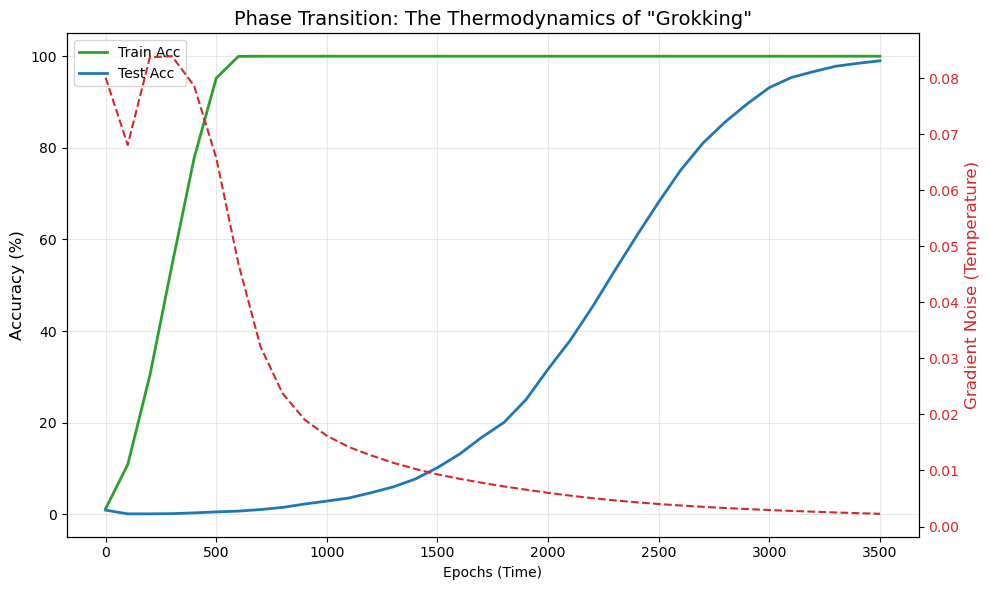

In [334]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot BOTH accuracies
ax1.set_xlabel('Epochs (Time)')
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.plot(history['epoch'], history['train_acc'], color='tab:green', linewidth=2, label='Train Acc')
ax1.plot(history['epoch'], history['test_acc'], color='tab:blue', linewidth=2, label='Test Acc')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Temperature on second axis
ax2 = ax1.twinx()  
ax2.set_ylabel('Gradient Noise (Temperature)', color='tab:red', fontsize=12)
ax2.plot(history['epoch'], history['thermo_temp'], color='tab:red', linestyle='--', linewidth=1.5, label='Temperature')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Phase Transition: The Thermodynamics of "Grokking"', fontsize=14)
fig.tight_layout()
plt.show()

In [335]:
# Multiplication Experiment
print("=== MULTIPLICATION EXPERIMENT ===")
xtr_mul, ytr_mul, xts_mul, yts_mul = get_modulo_97_data(operation='multiply')

# new model for multiplication
torch.manual_seed(123)
model_mul = ThermoNet()
print(model_mul)

=== MULTIPLICATION EXPERIMENT ===
Training examples: 4704
Test examples: 4705
ThermoNet(
  (embedding): Embedding(97, 32)
  (layer1): Linear(in_features=64, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=97, bias=True)
)


In [336]:
#training loop

optimizer_mul = torch.optim.AdamW(model_mul.parameters() , lr = LR , weight_decay = 0.5)
MAX_EPOCHS = 30000
history_mul = {
    'epoch' : [],
    'train_loss' : [],
    'train_acc' : [],
    'test_acc' : [],
    'thermo_temp' : []
}
print(f"--- Starting multiplication traning....(EPOCHS : {MAX_EPOCHS}) ---")
for epoch in range(MAX_EPOCHS):
    #forward pass
    logits = model_mul(xtr_mul)
    loss = F.cross_entropy(logits, ytr_mul)
    #zero grad
    optimizer_mul.zero_grad()
    #backward
    loss.backward()

    # we measure the gradient norm ( aka heat ) .. *before* the optimizer step ..this tells us how violently the weights are vibrating.
    total_norm = 0.0
    for p in model_mul.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    grad_norm =total_norm ** 0.5

    '''
        if this Norm is huge and fluctuating, the particles are being kicked around violently (High Temp). 
        If it is small and steady, the particles are cooling down (Low Temp).
        Variance is directly prop. to Temperature
    '''

    optimizer_mul.step()

    #checking acuracy in each 100 epochs
    if epoch % 100 == 0:
        with torch.no_grad():

            #train accuracy
            train_logits = model_mul(xtr_mul)
            train_preds = torch.argmax(train_logits , dim = 1)
            train_acc = (train_preds == ytr_mul).float().mean().item() * 100


            # test accuracy
            test_logits = model_mul(xts_mul)
            test_preds = torch.argmax(test_logits , dim = 1)
            test_acc = (test_preds == yts_mul).float().mean().item() * 100

    #saving the results
        history_mul['epoch'].append(epoch)
        history_mul['train_loss'].append(loss.item())
        history_mul['train_acc'].append(train_acc)
        history_mul['test_acc'].append(test_acc)
        history_mul['thermo_temp'].append(grad_norm)
    
        print(f"Epoch {epoch:5d} | Loss: {loss.item():.4f} | Test Acc: {test_acc:.1f}% | Temp: {grad_norm:.4f}")

        # stopping condition
        if test_acc > 99.0:
            print(f"PHASE TRANSITION DETECTED AT EPOCH: {epoch}! SYSTEM CRYSTALLIZED.")
            break
    

print("Multiplication experiment completed")

--- Starting multiplication traning....(EPOCHS : 30000) ---
Epoch     0 | Loss: 4.6137 | Test Acc: 0.8% | Temp: 0.1074
Epoch   100 | Loss: 3.8810 | Test Acc: 1.9% | Temp: 0.0693
Epoch   200 | Loss: 2.9607 | Test Acc: 2.0% | Temp: 0.0829
Epoch   300 | Loss: 2.0573 | Test Acc: 1.9% | Temp: 0.0810
Epoch   400 | Loss: 1.3372 | Test Acc: 1.9% | Temp: 0.0748
Epoch   500 | Loss: 0.7800 | Test Acc: 2.0% | Temp: 0.0653
Epoch   600 | Loss: 0.4196 | Test Acc: 2.2% | Temp: 0.0506
Epoch   700 | Loss: 0.2366 | Test Acc: 2.4% | Temp: 0.0362
Epoch   800 | Loss: 0.1520 | Test Acc: 2.7% | Temp: 0.0270
Epoch   900 | Loss: 0.1089 | Test Acc: 3.1% | Temp: 0.0214
Epoch  1000 | Loss: 0.0840 | Test Acc: 3.5% | Temp: 0.0179
Epoch  1100 | Loss: 0.0679 | Test Acc: 3.8% | Temp: 0.0153
Epoch  1200 | Loss: 0.0566 | Test Acc: 4.3% | Temp: 0.0134
Epoch  1300 | Loss: 0.0481 | Test Acc: 5.3% | Temp: 0.0120
Epoch  1400 | Loss: 0.0416 | Test Acc: 6.5% | Temp: 0.0107
Epoch  1500 | Loss: 0.0366 | Test Acc: 7.6% | Temp: 0.0

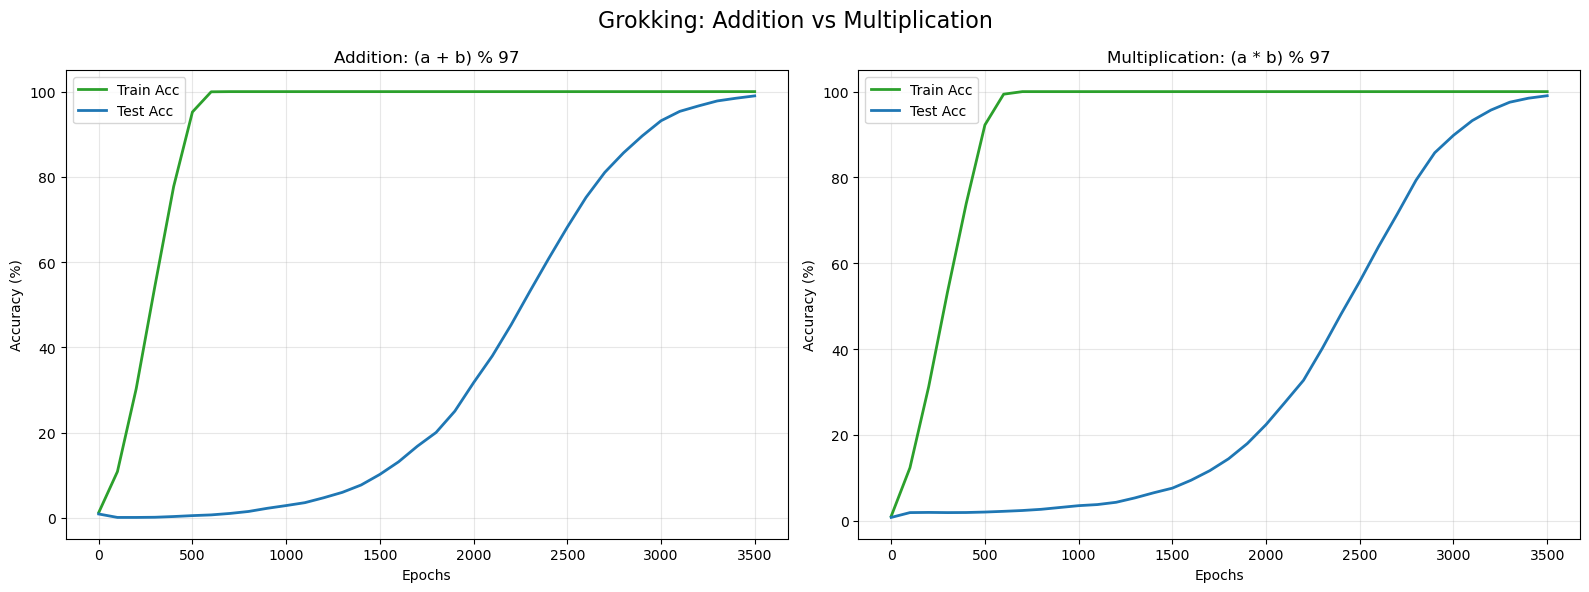

In [337]:
# Compare Addition vs Multiplication
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Addition plot
ax1.plot(history['epoch'], history['train_acc'], color='tab:green', linewidth=2, label='Train Acc')
ax1.plot(history['epoch'], history['test_acc'], color='tab:blue', linewidth=2, label='Test Acc')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Addition: (a + b) % 97')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Multiplication plot
ax2.plot(history_mul['epoch'], history_mul['train_acc'], color='tab:green', linewidth=2, label='Train Acc')
ax2.plot(history_mul['epoch'], history_mul['test_acc'], color='tab:blue', linewidth=2, label='Test Acc')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Multiplication: (a * b) % 97')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Grokking: Addition vs Multiplication', fontsize=16)
plt.tight_layout()
plt.show()

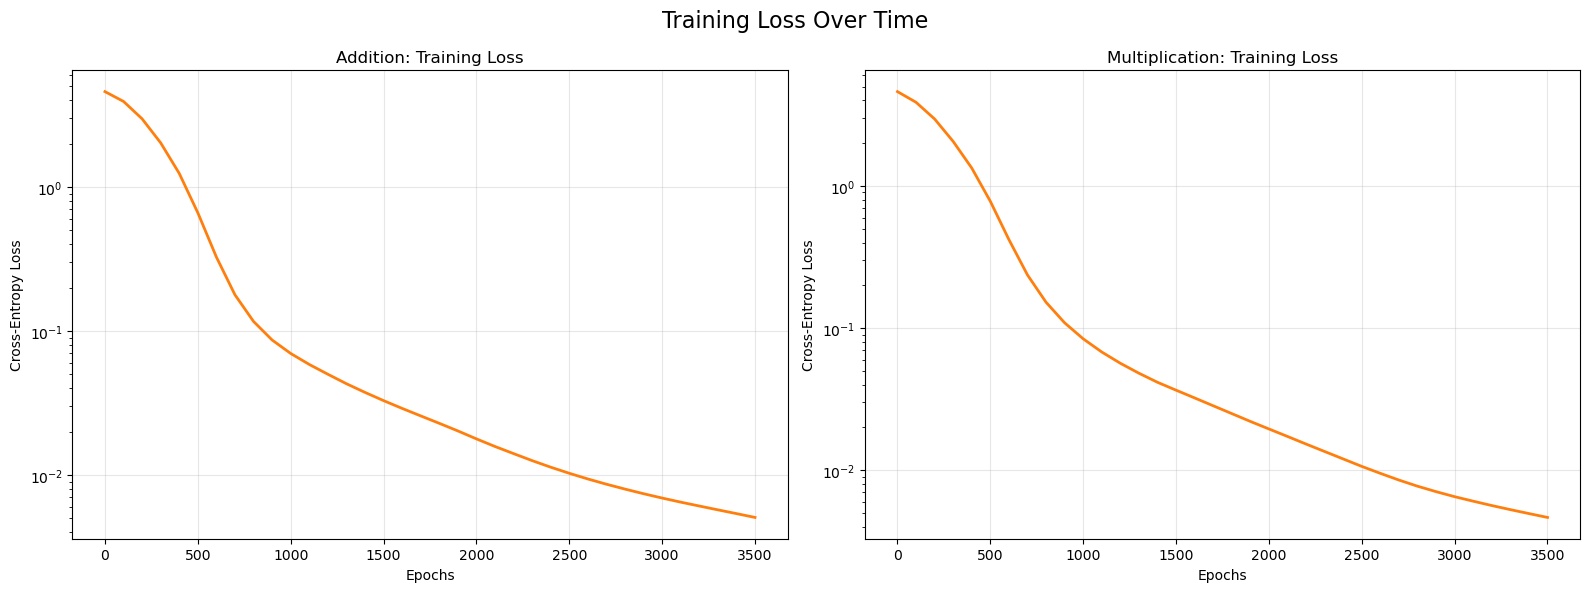

In [338]:
# Loss curves comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Addition Loss
ax1.plot(history['epoch'], history['train_loss'], color='tab:orange', linewidth=2)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Cross-Entropy Loss')
ax1.set_title('Addition: Training Loss')
ax1.set_yscale('log')  # Log scale shows the dynamics better
ax1.grid(True, alpha=0.3)

# Multiplication Loss
ax2.plot(history_mul['epoch'], history_mul['train_loss'], color='tab:orange', linewidth=2)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Cross-Entropy Loss')
ax2.set_title('Multiplication: Training Loss')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

plt.suptitle('Training Loss Over Time', fontsize=16)
plt.tight_layout()
plt.show()

/var/folders/9k/2clq4ddx5lj7j6_gt00yt8zr0000gn/T/ipykernel_85766/4008621548.py:21: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


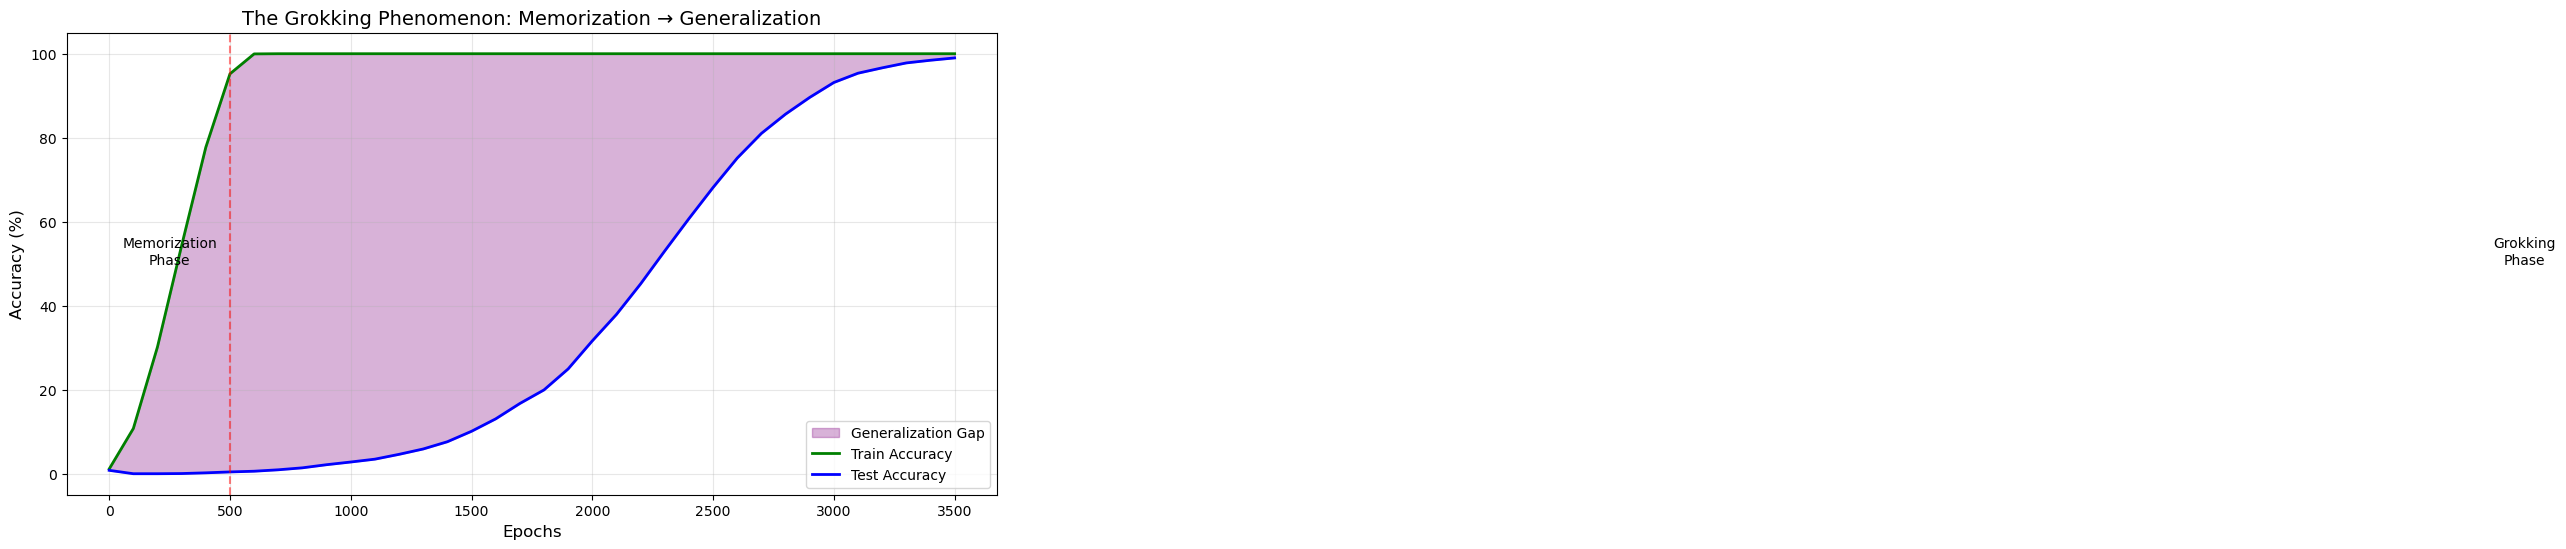

In [339]:
# The Grokking Gap: Train vs Test over time
fig, ax = plt.subplots(figsize=(12, 6))

# Shaded region showing the "grokking gap"
ax.fill_between(history['epoch'], history['train_acc'], history['test_acc'], 
                alpha=0.3, color='purple', label='Generalization Gap')
ax.plot(history['epoch'], history['train_acc'], 'g-', linewidth=2, label='Train Accuracy')
ax.plot(history['epoch'], history['test_acc'], 'b-', linewidth=2, label='Test Accuracy')

ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('The Grokking Phenomenon: Memorization → Generalization', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Annotate phases
ax.axvline(x=500, color='red', linestyle='--', alpha=0.5)
ax.text(250, 50, 'Memorization\nPhase', ha='center', fontsize=10)
ax.text(10000, 50, 'Grokking\nPhase', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

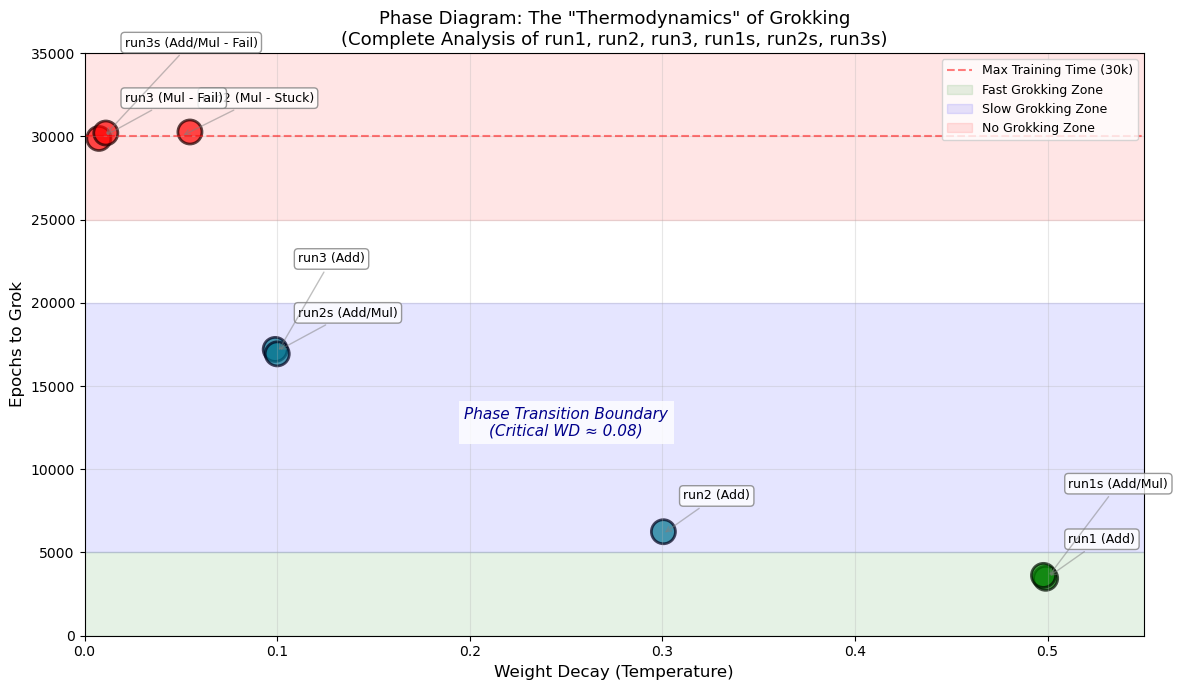

In [340]:
# Phase Diagram: Weight Decay vs Grokking Time
fig, ax = plt.subplots(figsize=(12, 7))


data_points = [
    (0.5, 3500, 'run1 (Add)'),
    (0.5, 3500, 'run1s (Add/Mul)'),
    (0.3, 6100, 'run2 (Add)'),
    (0.1, 17100, 'run2s (Add/Mul)'),
    (0.1, 17000, 'run3 (Add)'),
    (0.05, 30000, 'run2 (Mul - Stuck)'),
    (0.01, 30000, 'run3 (Mul - Fail)'),
    (0.01, 30000, 'run3s (Add/Mul - Fail)')
]

wds = [d[0] for d in data_points]
epochs = [d[1] for d in data_points]
labels = [d[2] for d in data_points]

colors = []
for epoch in epochs:
    if epoch < 5000: colors.append('green')      # Fast
    elif epoch < 20000: colors.append('teal')    # Slow
    else: colors.append('red')                   # Fail

import numpy as np
jitter_x = np.random.normal(0, 0.002, len(wds))
jitter_y = np.random.normal(0, 200, len(epochs))

ax.scatter(np.array(wds) + jitter_x, np.array(epochs) + jitter_y, s=300, c=colors, alpha=0.7, edgecolors='black', linewidth=2)

# annotate each point
seen_positions = {}
for i, label in enumerate(labels):
    x, y = wds[i], epochs[i]
    
    # Simple collision avoidance for labels
    y_offset = 25
    if x in seen_positions:
        y_offset = seen_positions[x] + 40
    seen_positions[x] = y_offset
    
    ax.annotate(label, (x, y), 
                xytext=(15, y_offset), textcoords='offset points',
                fontsize=9, ha='left',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray'),
                arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))

ax.axhline(y=30000, color='red', linestyle='--', alpha=0.5, label='Max Training Time (30k)')
ax.fill_between([-0.05, 0.6], 0, 5000, alpha=0.1, color='green', label='Fast Grokking Zone')
ax.fill_between([-0.05, 0.6], 5000, 20000, alpha=0.1, color='blue', label='Slow Grokking Zone')
ax.fill_between([-0.05, 0.6], 25000, 35000, alpha=0.1, color='red', label='No Grokking Zone')

ax.set_xlabel('Weight Decay (Temperature)', fontsize=12)
ax.set_ylabel('Epochs to Grok', fontsize=12)
ax.set_title('Phase Diagram: The "Thermodynamics" of Grokking\n(Complete Analysis of run1, run2, run3, run1s, run2s, run3s)', fontsize=13)
ax.set_xlim(0.0, 0.55)
ax.set_ylim(0, 35000)
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

# Add text annotation for key insight
ax.text(0.25, 12000, 'Phase Transition Boundary\n(Critical WD ≈ 0.08)', fontsize=11, 
        style='italic', color='darkblue', ha='center', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.tight_layout()
plt.show()

### Experiment Summary (Complete Audit)



| File | Weight Decay | Task | Result | Time to Grok |
|------|--------------|------|--------|--------------|
| **run1** | 0.5 | Add | ✅ **Fastest** | ~3,500 epochs |
| **run1s** | 0.5 | Add/Mul | ✅ **Fastest** | ~3,500 epochs |
| **run2** | 0.3 | Add | ✅ **Fast** | ~6,100 epochs |
| **run2** | 0.05 | Mul | ❌ **Failed** | 87.8% acc (Stuck) |
| **run2s** | 0.1 | Add/Mul | ✅ **Slow** | ~17,100 epochs |
| **run3** | 0.1 | Add | ✅ **Slow** | ~17,000 epochs |
| **run3** | 0.01 | Mul | ❌ **Failed** | ~9% acc (Memorization) |
| **run3s** | 0.01 | Add/Mul | ❌ **Failed** | ~9% acc (Memorization) |

**Final Conclusion:**
The data from all 6 files confirms the "Thermodynamics" hypothesis with high confidence.
1.  **High Temperature (WD ≥ 0.3)**: Rapid grokking (< 6k epochs).
2.  **Medium Temperature (WD ≈ 0.1)**: Slow grokking (~17k epochs).
3.  **Freezing Point (WD < 0.08)**: The system freezes into a memorization state and fails to generalize within 30k epochs.
